<center><img src=img/MScAI_brand.png width=70%></center>

# Scikit-Learn: Analysing Errors

After running the import/instantiate/fit/evaluate steps, we might see that our performance is not good enough on test data. Before deploying our model, we should diagnose the problem and see if we can fix it. In this notebook, we'll see a helpful tool for diagnosis.

The code and text are derived from https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression. I've mostly changed to use `meshgrid`.

In [8]:
import 

In [10]:
sklearn.__version__

'0.23.2'

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

First, generate some fake data:

In [2]:
X, y = make_classification(200, 2, 2, 0, weights=[.5, .5], 
                           random_state=15)
X_train, X_test, y_train, y_test = train_test_split(X, y)

/Users/jmmcd/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_informative=2, n_redundant=0 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


Now we take a look:

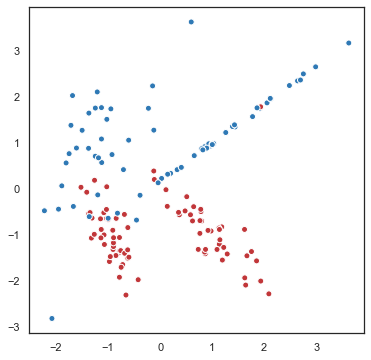

In [3]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X_train[:,0], X_train[:, 1], c=y_train,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1);

Fit the classifier to the training set:

In [7]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

solver parameter default value is going to change...

(`solver="lbfgs"` is just to silence a warning, we can ignore it.)

Next, make a square grid of values using `meshgrid`, which we saw when studying fractals. We have to manipulate a bit to get it into a format (a *tidy* format) expected by Scikit-Learn.

In [67]:
g = np.linspace(-5, 5, 101)
xg, yg = np.meshgrid(g, g)
xg = xg.flatten()
yg = yg.flatten()
Xg = np.array([xg, yg]).T

In [68]:
print(Xg[:3])
print("...")
print(Xg[99:103])
print("...")
print(Xg[-3:])

[[-5.  -5. ]
 [-4.9 -5. ]
 [-4.8 -5. ]]
...
[[ 4.9 -5. ]
 [ 5.  -5. ]
 [-5.  -4.9]
 [-4.9 -4.9]]
...
[[4.8 5. ]
 [4.9 5. ]
 [5.  5. ]]


Next we evaluate the probability of each point in the grid. 

In [69]:
probs = clf.predict_proba(Xg)
probs[:5]

array([[9.99816941e-01, 1.83059102e-04],
       [9.99829506e-01, 1.70494015e-04],
       [9.99841209e-01, 1.58791252e-04],
       [9.99852108e-01, 1.47891651e-04],
       [9.99862260e-01, 1.37740108e-04]])

But our model returns a vector of probabilities for each $X$: $(P(y=0), P(y=1))$. This is redundant and we can only visualise one colour per pixel, so we take $P(y=1)$ only.

In [70]:
probs = probs[:, 1]
probs[:5]

array([0.00018306, 0.00017049, 0.00015879, 0.00014789, 0.00013774])

Now we reshape back to a square grid.

In [71]:
probs = probs.reshape(101, 101)

Now, plot the probability grid as a contour map and additionally show the test set samples on top of it. There is quite a bit going on here. No need to remember details. Unfortunately it has to go all in one cell, and doesn't fit on a single slide. So, if you want to read the code, please just see the `.ipynb` file.

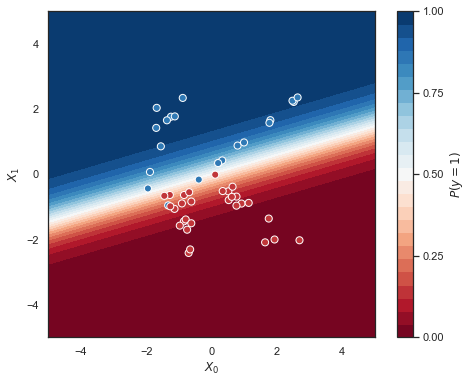

In [74]:
f, ax = plt.subplots(figsize=(8, 6))

# contourf -> contour plot
# RdBu -> Red to Blue colour map
# vmin, vmax -> bounds on probs
contour = ax.contourf(g, g, probs, 25, cmap="RdBu", vmin=0, vmax=1)

# colorbar -> legend
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

# s -> marker size
ax.scatter(X_test[:,0], X_test[:, 1], c=y_test, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_0$", ylabel="$X_1$");

This is the space of independent variables, with each point in the grid coloured by its value of $P(y=1)$. If we take the decision boundary at $P(y=1)=1/2$ (or any other threshold) then we have a linear decision boundary as expected.

We also see the test points, and we can clearly see a few individual errors, i.e. blue points in the red area and vice versa. By creating a plot like this, we can look at individual errors and start to investigate them.

### Further reading

Another useful tool is the *confusion matrix*. See https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Classification-on-digits for an example.

### Further ideas

Depending on our problem, it might be interesting to plot other items, such as
a sample of the training data, with a different marker shape from the test data.

### Exercise

1. Almost everything here is *generic*, not specific to the `LogisticRegression` classifier. By the principle of duck typing, the only requirement is that our classifier:
  * must have `fit()` (they all do, of course) and 
  * it must allow `predict_proba()` (not just `predict()`). 

Does `SVC` work? Replace `LogisticRegression` with `SVC` and re-run.

### Exercise

2. Some classifiers don't even have a `predict_proba` method, but in `SVC` it just refuses to work -- **unless** we call the constructor with `SVC(probability=True)`. So, do that, and re-run, and take a look at the new decision boundary. What is it like?

### Solutions

1. As you know if you saw **Exercise 2**, the answer is no. You'll see an error about "probability is False". 

2. Now the decision boundary is *non-linear*, and seems to skirt nicely around the data.